# Topo MWTA Cifar10

## Intro 
* **Date**: 1/13/2021
* **What**: This is basically the exact same architecture as the previous experiment, but just trained on gray-scale cifar.
* **Why**: Because I desperately yearn to see the topology learned on cifar.
* **Hopes**: I want me some good topology.
* **Limitations**: Oh, all the usual suspects.

## Code

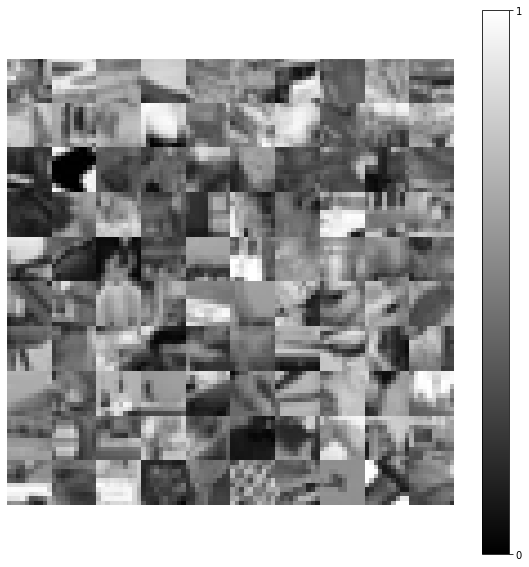

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import cifar10
from tqdm import tqdm

(x_tr, _), (x_te, _) = cifar10.load_data()

sl = 32

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="gray", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

gray_x = np.linalg.norm(x_tr / 255., axis=1)
te_x = np.linalg.norm(x_te / 255., axis=1)

x10 = gray_x[:, 11:21, 11:21]
x10_te = te_x[:, 11:21, 11:21]

flat_x10 = x10.reshape(-1, 100) / np.max(x10)
flat_te = x10_te.reshape(-1, 100) / np.max(x10_te)

fig = plt.figure(figsize=(10, 10))

draw_weights(flat_te, 10, 10, 10, fig)

In [2]:
gp_x10 = cp.asarray(flat_x10)
gp_te = cp.asarray(flat_te)

In [3]:
sl = 10

## Analysis Dialog

Aight bois, get hyped!

<IPython.core.display.Javascript object>


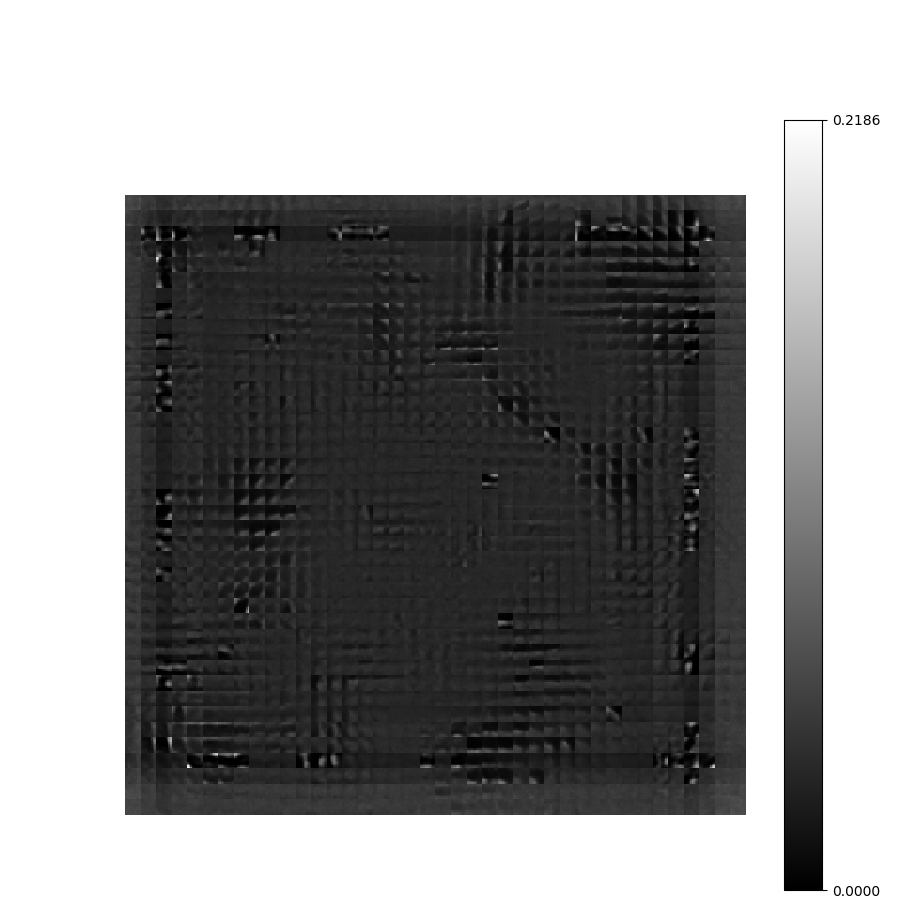

 27%|██▋       | 2703/10000 [00:01<00:04, 1503.22it/s]


KeyboardInterrupt: 

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 2

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.02

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.5

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

That looks like the topology is too strong.  Decreasing the topology, increasing the number of winners.

<IPython.core.display.Javascript object>


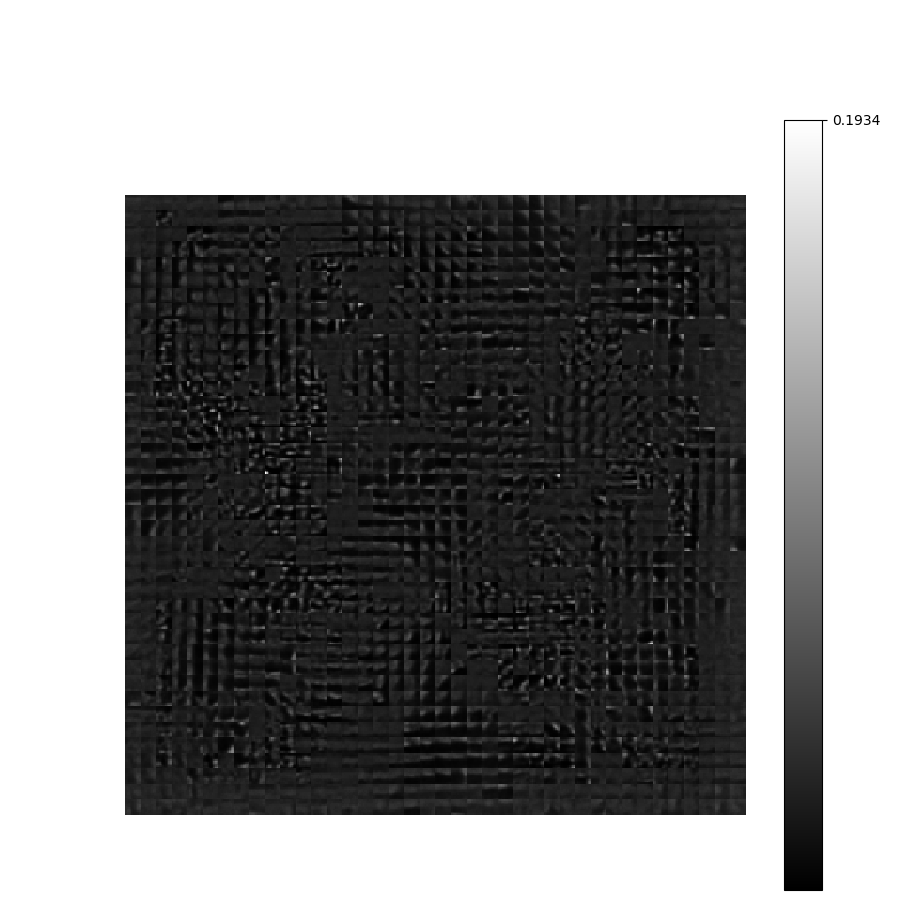

 65%|██████▌   | 6526/10000 [00:04<00:02, 1570.21it/s]


KeyboardInterrupt: 

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 2

prec = 1e-10

n_w = 20 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.02

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.2

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


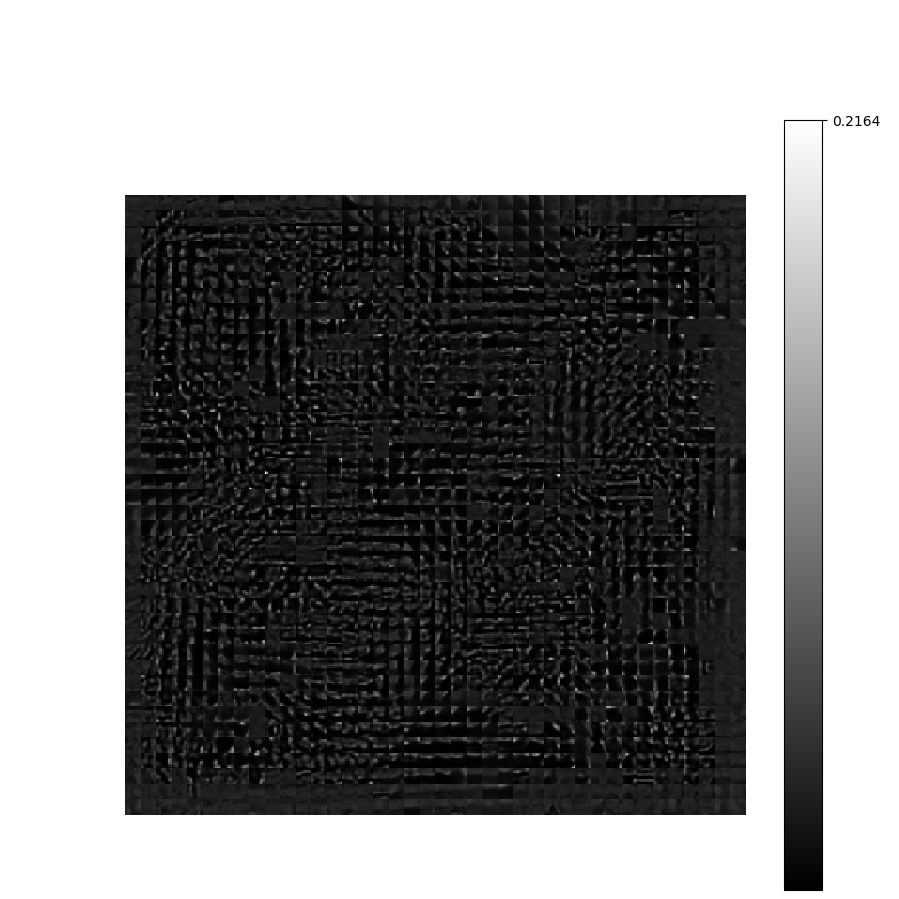

 93%|█████████▎| 9347/10000 [00:05<00:00, 1574.74it/s]


KeyboardInterrupt: 

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 100
T_s = 10_000


for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

In [4]:
def reconstruct(img_i, sw):
    v = gp_x10[img_i].reshape(-1, 1)

    p = sw @ v
    c = p + (lat_ex @ p)
    winners = cp.argsort(c, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    tap = np.zeros((10, 20))
    tap[:, :10] = v.get().reshape(10, 10)
    tap[:, 10:] = r.get().reshape(10, 10)

    plt.figure(figsize=(2, 1)) # Added this line after many of the trials
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tap, cmap='gray')
    plt.show()

In [5]:
def reconstruct_te(img_i, sw):
    v = gp_te[img_i].reshape(-1, 1)

    p = sw @ v
    c = p + (lat_ex @ p)
    winners = cp.argsort(c, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    tap = np.zeros((10, 20))
    tap[:, :10] = v.get().reshape(10, 10)
    tap[:, 10:] = r.get().reshape(10, 10)

    plt.figure(figsize=(2, 1)) # Added this line after many of the trials
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tap, cmap='gray')
    plt.show()

<IPython.core.display.Javascript object>


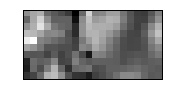

<IPython.core.display.Javascript object>


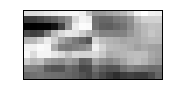

<IPython.core.display.Javascript object>


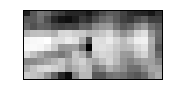

<IPython.core.display.Javascript object>


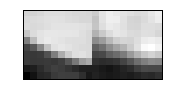

<IPython.core.display.Javascript object>


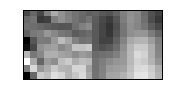

<IPython.core.display.Javascript object>


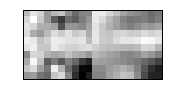

<IPython.core.display.Javascript object>


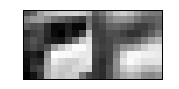

<IPython.core.display.Javascript object>


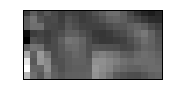

<IPython.core.display.Javascript object>


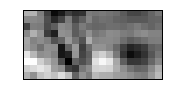

<IPython.core.display.Javascript object>


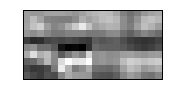

In [21]:
offset = 0

for i in range(10):
    reconstruct_te(offset + i, w)

Those reconstructions are honestly better than what I was expecting.  I'm going to increase the range of the topology.

<IPython.core.display.Javascript object>


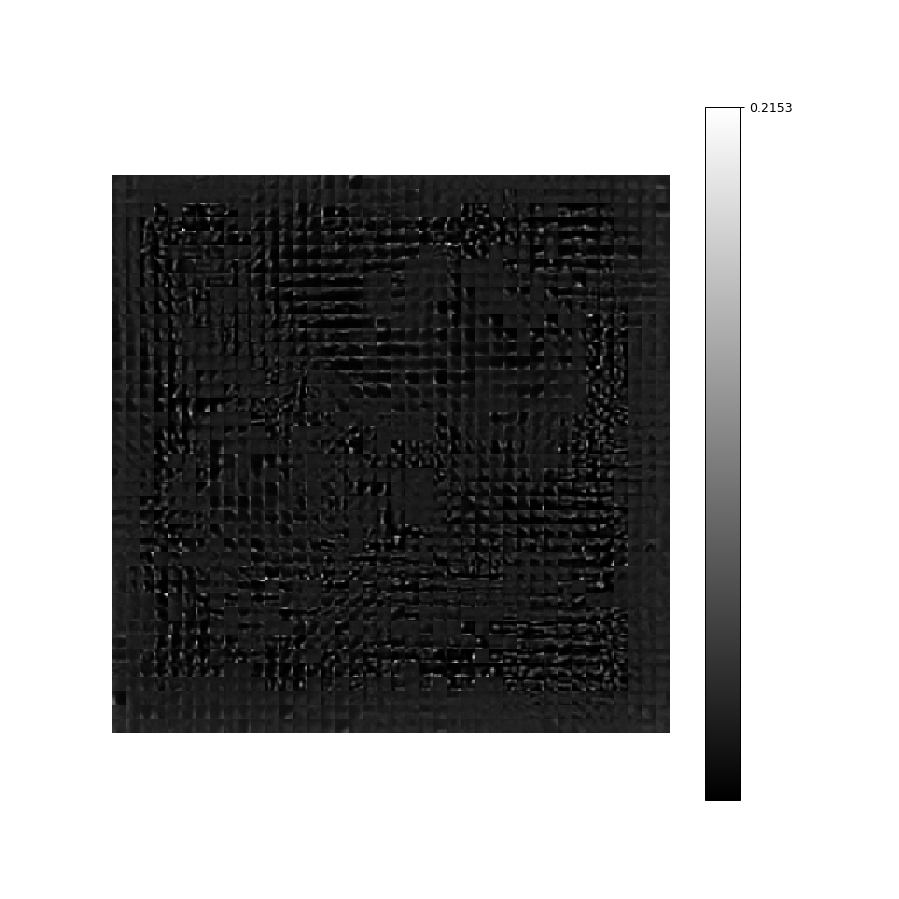

100%|██████████| 10000/10000 [00:06<00:00, 1571.22it/s]


In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 3

prec = 1e-10

n_w = 20 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.02

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.2

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


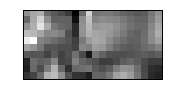

<IPython.core.display.Javascript object>


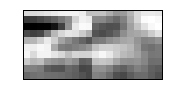

<IPython.core.display.Javascript object>


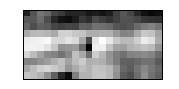

<IPython.core.display.Javascript object>


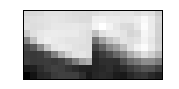

<IPython.core.display.Javascript object>


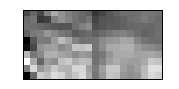

<IPython.core.display.Javascript object>


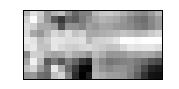

<IPython.core.display.Javascript object>


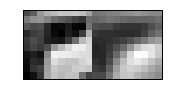

<IPython.core.display.Javascript object>


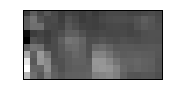

<IPython.core.display.Javascript object>


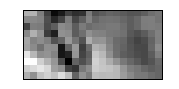

<IPython.core.display.Javascript object>


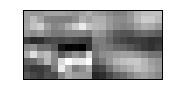

In [23]:
offset = 0

for i in range(10):
    reconstruct_te(offset + i, w)

Ok, I'm going to use a huge network now. 

<IPython.core.display.Javascript object>


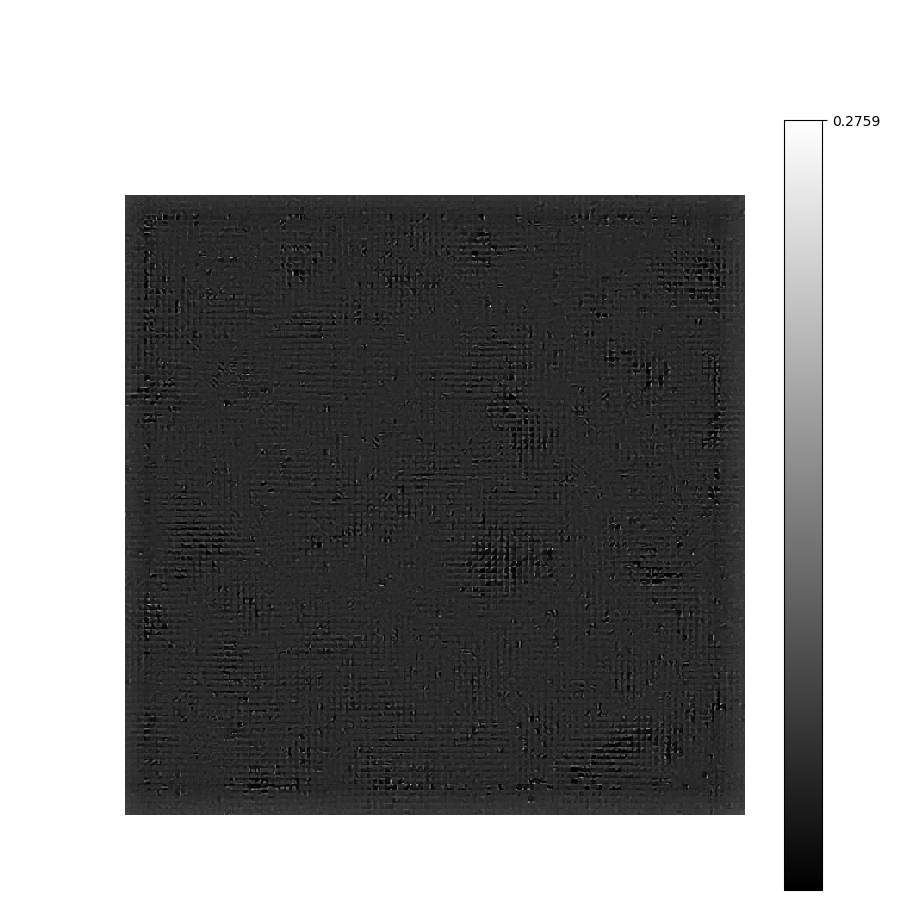

 80%|███████▉  | 7958/10000 [00:17<00:04, 452.85it/s]

KeyboardInterrupt: 

In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 3

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.08

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.2

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

I think a bigger learning constant could do that network some good.

<IPython.core.display.Javascript object>


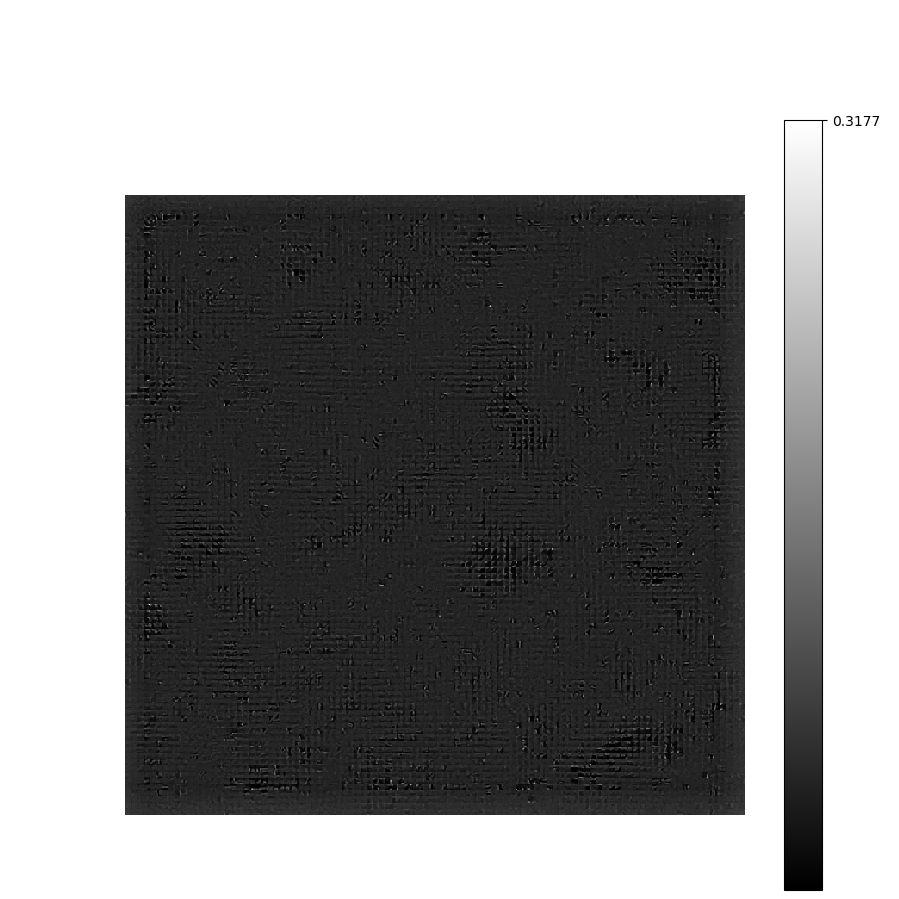


 24%|██▍       | 2438/10000 [00:24<00:16, 448.75it/s]

KeyboardInterrupt: 

In [26]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 5_000

xi = 0.1

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in range(T_s):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Ok, something went wrong.  Let's see some reconstructions!

<IPython.core.display.Javascript object>


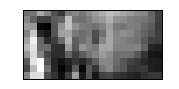

<IPython.core.display.Javascript object>


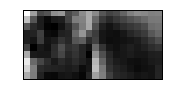

<IPython.core.display.Javascript object>


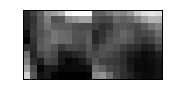

<IPython.core.display.Javascript object>


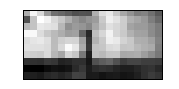

<IPython.core.display.Javascript object>


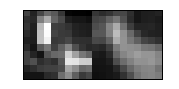

<IPython.core.display.Javascript object>


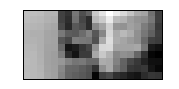

<IPython.core.display.Javascript object>


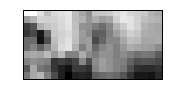

<IPython.core.display.Javascript object>


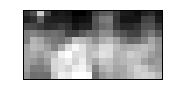

<IPython.core.display.Javascript object>


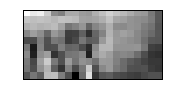

<IPython.core.display.Javascript object>


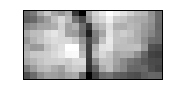

In [29]:
offset = 10

for i in range(10):
    reconstruct(offset + i, w)

Something's rotten in the state of Denmark.  That being said, the topology that this network is learning is incredibly dope.  

I'm going to try weaker topology on a smaller network, see what's good.

<IPython.core.display.Javascript object>


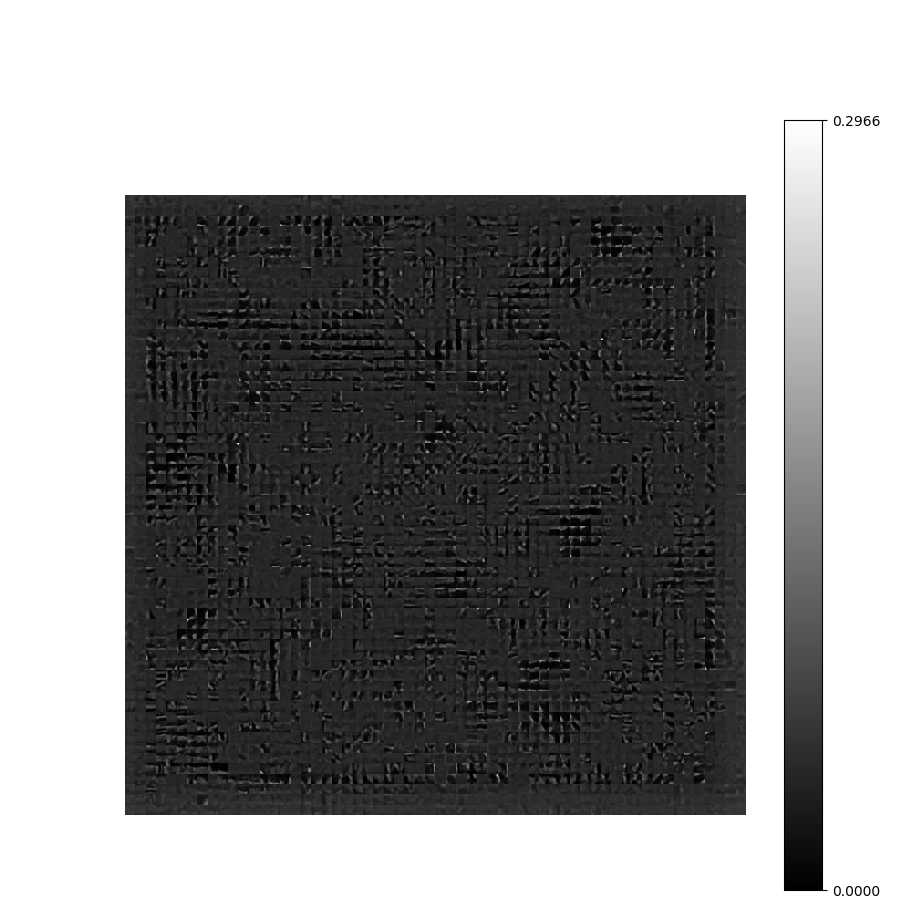

 39%|███▊      | 3865/10000 [00:03<00:06, 1020.41it/s]


KeyboardInterrupt: 

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 60
Ky = 60
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.05

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.2

for ep in range(Nep):
    inputs = gp_x10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        cp.clip(w, 0, 1, out=w)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

## Conclusions

There be topology bois.  Wow Bios and Bois are only separated by a single parity.  Interesting how the world works.  Anyway, this is super dope.

## Next steps

Hook this into an invariant layer and see what comes out.